In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [29]:
"""
    Global variables.
    DATA_DIR -> the directory where the files are located
    DATA_FILE -> the file where we get the input
"""
DATA_DIR = 'F:/Python/Time Series - Airbnb/data/'
DATA_FILE = 'reviews.csv'

In [30]:
data = pd.read_csv(DATA_DIR+DATA_FILE)

In [31]:
"""
    Looking at the data and getting basic information:
"""
display('Looking at the first 5 rows:',data.head())
display('Looking at the shape of our data:',data.shape)
display('Looking if there are some NULL values:',data.isnull().any())
display('Looking at the type of our data:',data.dtypes)
display('Some descriptive data:',data.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]))

'Looking at the first 5 rows:'

,listing_id,date
0,109,2011-08-15
1,109,2016-05-15
2,344,2016-06-14
3,344,2016-12-11
4,344,2016-12-30


'Looking at the shape of our data:'

(1427153, 2)

'Looking if there are some NULL values:'

listing_id    False
date          False
dtype: bool

'Looking at the type of our data:'

listing_id     int64
date          object
dtype: object

'Some descriptive data:'

,listing_id
count,1.427153e+06
mean,1.372584e+07
std,9.224988e+06
min,1.090000e+02
25%,5.220845e+06
50%,1.376222e+07
75%,2.090521e+07
90%,2.647792e+07
95%,2.961650e+07
99%,3.337584e+07


In [32]:
"""
    Basic data transformations before applying statistical methods.
    Renaming the columns to a more simple way, grouping our listing ids to data, setting the data as index and
    inputting the missing dates.
"""
import datetime

data = data.rename(columns = {'date':'ds','listing_id':'ts'})
data_exemple = data.groupby(by = 'ds').agg({'ts':'count'})
data_exemple.index = pd.to_datetime(data_exemple.index)

data_exemple = data_exemple.asfreq('1D')
data_exemple = data_exemple.sort_index(ascending = True)

data_exemple.fillna(value = 0,inplace=True)

display(data_exemple.tail())

,ts
ds,
2019-07-05,981.0
2019-07-06,954.0
2019-07-07,1524.0
2019-07-08,370.0
2019-07-09,1.0


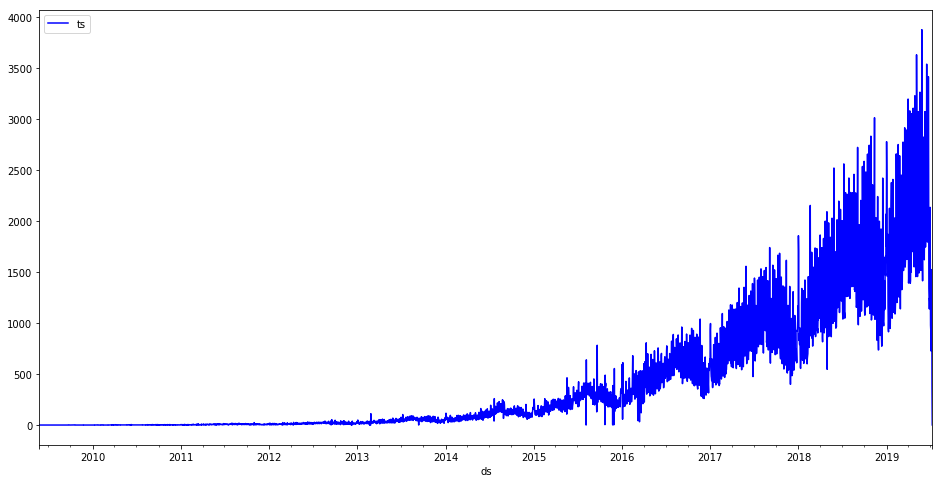

In [33]:
f,ax = plt.subplots(figsize=(16,8))
data_exemple.plot(ax=ax,color='blue')

In [34]:
"""
    Looking for stationary, using Rolling Statistics, ADF and KPSS.
"""
from statsmodels.tsa.stattools import adfuller, kpss
def test_stationarity(df,ts,significance_level=0.05):
    
    #Rolling statistics
    roll_mean = df[ts].rolling(12).mean()
    roll_std = df[ts].rolling(12).std()
    
    #Plotting rolling statistics
    plt.plot(df[ts],color='blue',label='Original TS')
    plt.plot(roll_mean,color='red',label='Rolling Mean')
    plt.plot(roll_std,color='black',label='Rolling STD')
    
    plt.show(block = False)
    plt.close()
    #ADF Test
    test_adf = adfuller(df[ts], autolag='AIC')
    p_value = test_adf[1]
    display('TS is stationary according to ADF Test?:',p_value<significance_level)
    
    dfoutput = pd.Series(test_adf[0:4],
                        index=['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in test_adf[4].items():
        dfoutput['Critical Value (%s)'%key] = value 
    display(dfoutput)
    
    #KPSS Test
    test_kpss = kpss(df[ts])
    p_value = test_kpss[1]
    display('TS is stationary according to KPSS Test?:',p_value>significance_level)

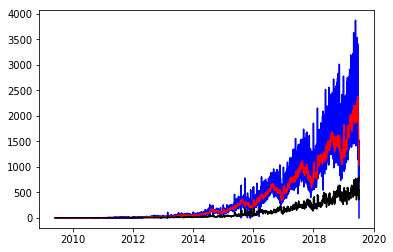

'TS is stationary according to ADF Test?:'

False

Test Statistic                   -1.547286
p-value                           0.510003
# Lags Used                      30.000000
Number of Observations Used    3666.000000
Critical Value (1%)              -3.432135
Critical Value (5%)              -2.862329
Critical Value (10%)             -2.567190
dtype: float64

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


'TS is stationary according to KPSS Test?:'

False

In [35]:
test_stationarity(data_exemple,'ts',0.05)

In [36]:
"""
    As we can see from above the TS is not stationary and we must make it stationary.
"""
def plot_transformed_data(df,ts,ts_transform):
    #Plotting the transformed time series
    f,ax = plt.subplots(1,1)
    ax.plot(df[ts],color='blue')
    ax.plot(df[ts_transform],color='red')
    
    ax.set_title(f'{ts} and {ts_transform} time series graphs')
    ax.legend([ts,ts_transform])
    
    plt.show()
    plt.close()

In [37]:
#Log transformation on data
data_exemple['ts_log'] = np.log(data_exemple['ts'])

#Moving average 7days on log transformation
data_exemple['ts_log_moving_avg'] = data_exemple['ts_log'].rolling(7).mean()

#Moving average 7days on normal data
data_exemple['ts_moving_avg'] = data_exemple['ts'].rolling(7).mean()

#First difference on log data
data_exemple['ts_log_diff'] = data_exemple['ts_log'] - data_exemple['ts_log'].shift()

#Difference with moving average
data_exemple['ts_moving_avg_diff'] = data_exemple['ts'] - data_exemple['ts_moving_avg']

#Difference with log moving average
data_exemple['ts_log_moving_avg_diff'] = data_exemple['ts_log'] - data_exemple['ts_log_moving_avg']

data_exemple_transform = data_exemple.dropna()

#EWNA Transformation on log
data_exemple_transform['ts_log_ewma'] = pd.DataFrame(data_exemple_transform['ts_log']).ewm(halflife = 7,
                                                                         ignore_na = False,
                                                                         min_periods = 0,
                                                                         adjust = True).mean()

data_exemple_transform['ts_log_ewma_diff'] = data_exemple_transform['ts_log'] - data_exemple_transform['ts_log_ewma']

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ts,ts_log,ts_log_moving_avg,ts_moving_avg,ts_log_diff,ts_moving_avg_diff,ts_log_moving_avg_diff,ts_log_ewma,ts_log_ewma_diff
ds,,,,,,,,,
2010-07-04,1.0,0.000000,0.198042,1.285714,-0.693147,-0.285714,-0.198042,0.000000,0.000000
2010-07-05,1.0,0.000000,0.099021,1.142857,0.000000,-0.142857,-0.099021,0.000000,0.000000
2010-07-06,1.0,0.000000,0.099021,1.142857,0.000000,-0.142857,-0.099021,0.000000,0.000000
2010-07-16,2.0,0.693147,0.594126,1.857143,0.000000,0.142857,0.099021,0.199809,0.493339
2010-07-28,1.0,0.000000,0.255966,1.428571,0.000000,-0.428571,-0.255966,0.151569,-0.151569


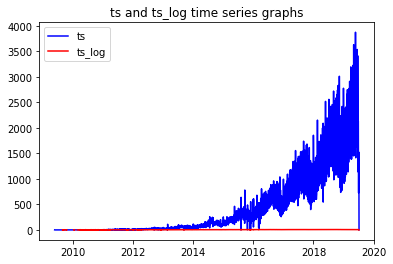

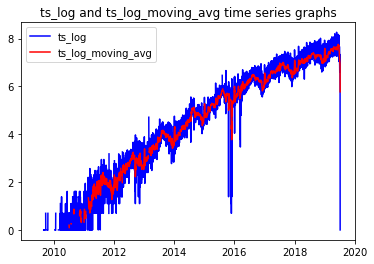

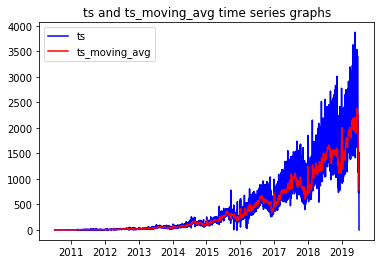

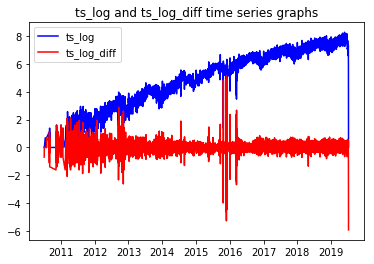

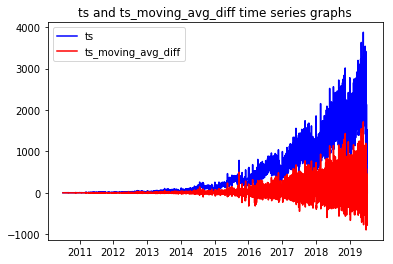

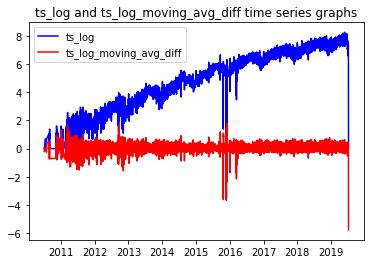

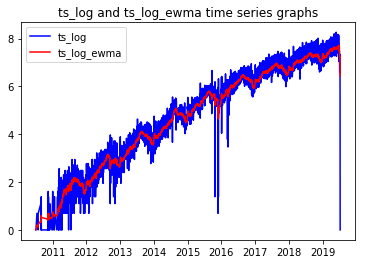

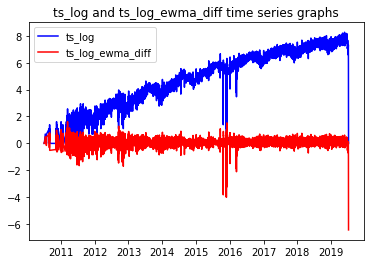

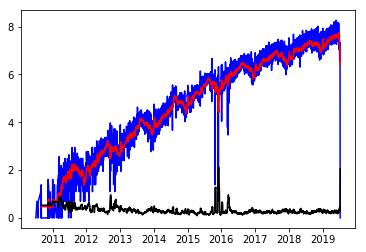

'TS is stationary according to ADF Test?:'

False

Test Statistic                   -2.550924
p-value                           0.103570
# Lags Used                      27.000000
Number of Observations Used    2987.000000
Critical Value (1%)              -3.432541
Critical Value (5%)              -2.862508
Critical Value (10%)             -2.567285
dtype: float64

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


'TS is stationary according to KPSS Test?:'

False

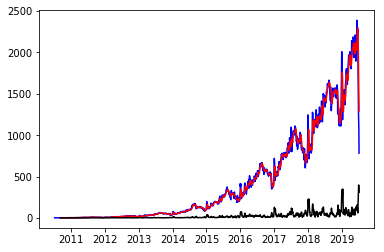

'TS is stationary according to ADF Test?:'

False

Test Statistic                   -0.895957
p-value                           0.789301
# Lags Used                      28.000000
Number of Observations Used    2986.000000
Critical Value (1%)              -3.432542
Critical Value (5%)              -2.862508
Critical Value (10%)             -2.567286
dtype: float64

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


'TS is stationary according to KPSS Test?:'

False

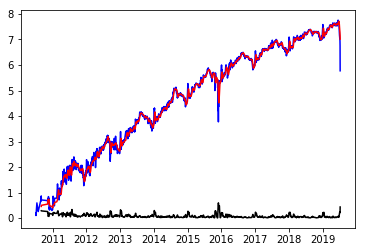

'TS is stationary according to ADF Test?:'

False

Test Statistic                   -2.571320
p-value                           0.099071
# Lags Used                      28.000000
Number of Observations Used    2986.000000
Critical Value (1%)              -3.432542
Critical Value (5%)              -2.862508
Critical Value (10%)             -2.567286
dtype: float64

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


'TS is stationary according to KPSS Test?:'

False

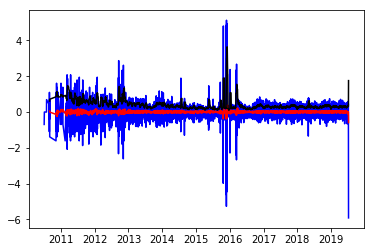

'TS is stationary according to ADF Test?:'

True

Test Statistic                -1.257654e+01
p-value                        1.951806e-23
# Lags Used                    2.600000e+01
Number of Observations Used    2.988000e+03
Critical Value (1%)           -3.432540e+00
Critical Value (5%)           -2.862508e+00
Critical Value (10%)          -2.567285e+00
dtype: float64

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


'TS is stationary according to KPSS Test?:'

True

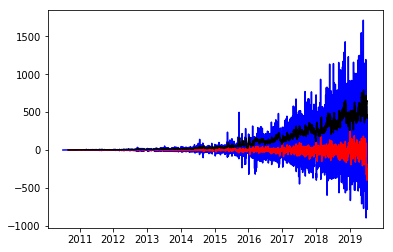

'TS is stationary according to ADF Test?:'

True

Test Statistic                -7.864427e+00
p-value                        5.180186e-12
# Lags Used                    2.900000e+01
Number of Observations Used    2.985000e+03
Critical Value (1%)           -3.432543e+00
Critical Value (5%)           -2.862509e+00
Critical Value (10%)          -2.567286e+00
dtype: float64

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


'TS is stationary according to KPSS Test?:'

True

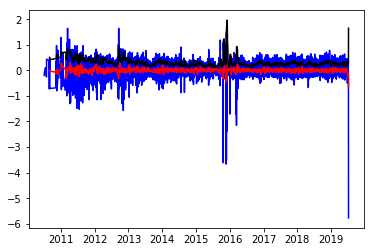

'TS is stationary according to ADF Test?:'

True

Test Statistic                -1.028938e+01
p-value                        3.603529e-18
# Lags Used                    2.900000e+01
Number of Observations Used    2.985000e+03
Critical Value (1%)           -3.432543e+00
Critical Value (5%)           -2.862509e+00
Critical Value (10%)          -2.567286e+00
dtype: float64

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


'TS is stationary according to KPSS Test?:'

True

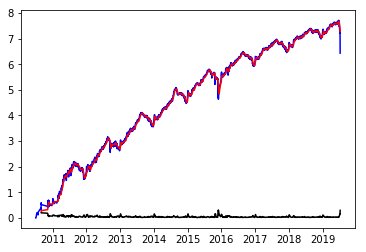

'TS is stationary according to ADF Test?:'

False

Test Statistic                   -2.683667
p-value                           0.076908
# Lags Used                      28.000000
Number of Observations Used    2986.000000
Critical Value (1%)              -3.432542
Critical Value (5%)              -2.862508
Critical Value (10%)             -2.567286
dtype: float64

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


'TS is stationary according to KPSS Test?:'

False

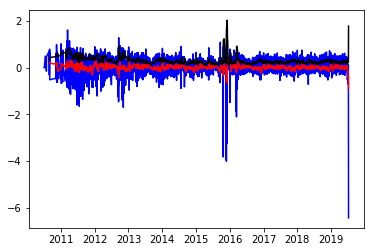

'TS is stationary according to ADF Test?:'

True

Test Statistic                -7.847387e+00
p-value                        5.720785e-12
# Lags Used                    2.700000e+01
Number of Observations Used    2.987000e+03
Critical Value (1%)           -3.432541e+00
Critical Value (5%)           -2.862508e+00
Critical Value (10%)          -2.567285e+00
dtype: float64

'TS is stationary according to KPSS Test?:'

False

In [38]:
"""
    Plotting our results
"""

# Display data
display(data_exemple_transform.head())

# Plot data
plot_transformed_data(df = data_exemple, 
                      ts = 'ts', 
                      ts_transform = 'ts_log')
# Plot data
plot_transformed_data(df = data_exemple, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg')

# Plot data
plot_transformed_data(df = data_exemple_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg')

# Plot data
plot_transformed_data(df = data_exemple_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_diff')

# Plot data
plot_transformed_data(df = data_exemple_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg_diff')

# Plot data
plot_transformed_data(df = data_exemple_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg_diff')

# Plot data
plot_transformed_data(df = data_exemple_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma')

# Plot data
plot_transformed_data(df = data_exemple_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma_diff')

# Perform stationarity test
test_stationarity(df = data_exemple_transform, 
                  ts = 'ts_log')

# Perform stationarity test
test_stationarity(df = data_exemple_transform, 
                  ts = 'ts_moving_avg')

# Perform stationarity test
test_stationarity(df = data_exemple_transform, 
                  ts = 'ts_log_moving_avg')

# Perform stationarity test
test_stationarity(df = data_exemple_transform,
                  ts = 'ts_log_diff')

# Perform stationarity test
test_stationarity(df = data_exemple_transform,
                  ts = 'ts_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = data_exemple_transform,
                  ts = 'ts_log_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = data_exemple_transform, 
                  ts = 'ts_log_ewma')

# Perform stationarity test
test_stationarity(df = data_exemple_transform,
                  ts = 'ts_log_ewma_diff')

In [39]:
"""
    Decomposition.
"""
def plot_decomposition(df,ts,trend,seasonal,residual):
    #Plotting the trend, seasonal and residual graphics
    f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize = (15, 5),sharex = True)
    ax1.plot(df[ts],label='Original')
    ax1.legend(loc = 'best')
    
    ax2.plot(df[trend],label='Trend')
    ax2.legend(loc = 'best')
    
    ax3.plot(df[seasonal],label='Seasonal')
    ax3.legend(loc = 'best')
    
    ax4.plot(df[residual],label='Residual')
    ax4.legend(loc = 'best')
    
    plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
    
    plt.show()
    plt.close()

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

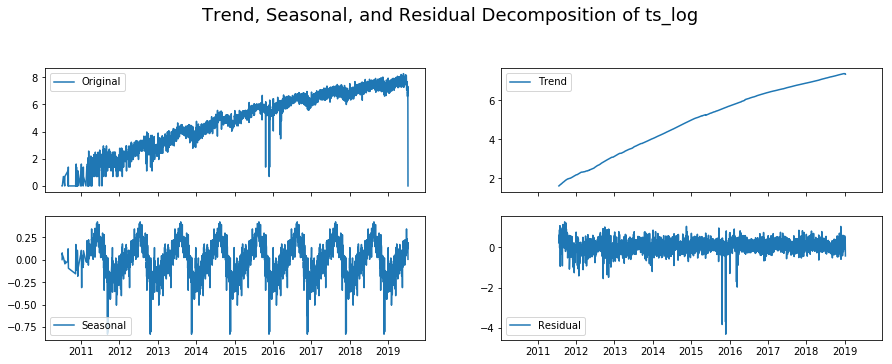

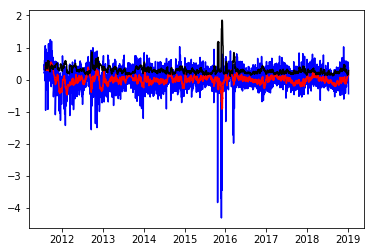

'TS is stationary according to ADF Test?:'

True

Test Statistic                -7.223732e+00
p-value                        2.079000e-10
# Lags Used                    2.700000e+01
Number of Observations Used    2.623000e+03
Critical Value (1%)           -3.432846e+00
Critical Value (5%)           -2.862643e+00
Critical Value (10%)          -2.567357e+00
dtype: float64

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


'TS is stationary according to KPSS Test?:'

True

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_exemple_transform['ts_log'], freq = 365)
data_exemple_transform['trend'] = decomposition.trend
data_exemple_transform['seasonal'] = decomposition.seasonal
data_exemple_transform['resid'] = decomposition.resid

plot_decomposition(data_exemple_transform,'ts_log','trend','seasonal','resid')

test_stationarity(data_exemple_transform.dropna(),'resid')

In [41]:
data_exemple_transform.to_csv('data_for_prediction.csv')